In [ ]:
!ls
!pip3 install torch torchvision
!pip3 install -q kaggle

kaggle.json  sample_data  train.csv


In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-256x256


 97% 536M/550M [00:06<00:00, 137MB/s]
100% 550M/550M [00:06<00:00, 91.3MB/s]


In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-yolo-labels-dataset

100% 4.85M/4.85M [00:00<00:00, 43.9MB/s]



In [ ]:
!unzip ./vinbigdata-yolo-labels-dataset.zip

In [ ]:
!unzip ./vinbigdata-chest-xray-resized-png-256x256.zip

In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

Add more columns to match the YOLO requirement



In [ ]:
train_df = pd.read_csv(f'./train.csv')

train_df['image_path'] = f'./train/'+train_df.image_id+'.png'
#remove the no finding class
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
print (train_df.head())

                           image_id          class_name  ...         h      area
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...  0.195205  0.090283
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...  0.095833  0.014433
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening  ...  0.024740  0.003117
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD  ...  0.753033  0.277156
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass  ...  0.039368  0.001809

[5 rows x 16 columns]


In [ ]:
# create split of training and validation
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_df,y,test_size=0.2,random_state=123)


4


(3515, 879)

Customizing the directory setup for YOLO

In [ ]:
import shutil, os
from tqdm.notebook import tqdm

os.makedirs('./labels/train', exist_ok = True)
os.makedirs('./labels/val', exist_ok = True)
os.makedirs('./images/train', exist_ok = True)
os.makedirs('./images/val', exist_ok = True)
label_dir = './labels'
for file in tqdm(train_files):
    #try:
      shutil.copy(file, './images/train')
      filename = file.split('/')[-1].split('.')[0]
      shutil.copy(os.path.join(label_dir, filename+'.txt'), './labels/train')
    #except:
      #pass
    
for file in tqdm(val_files):
    shutil.copy(file, './images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), './labels/val')

In [ ]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

creating the yaml file for data, based on reference: https://colab.research.google.com/drive/1gDZ2xcTOgR39tGGs-EZ6i3RTs16wmzZQ#scrollTo=1Rvt5wilnDyX

In [1]:
%cat ./vinbigdata.yaml

names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: ../train.txt
val: ../val.txt


Downloading the yolo5 repository


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 6135, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 6135 (delta 88), reused 97 (delta 61), pack-reused 5980
Receiving objects: 100% (6135/6135), 8.73 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (4177/4177), done.


In [ ]:
os.chdir('./yolov5')
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 CPU


In [ ]:
!cat ../vinbigdata.yaml

names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: ../train.txt
val: ../val.txt


Training the model

In [ ]:
!WANDB_MODE="dryrun" python train.py --img-size 256 --batch 15 --epochs 10 --data ../vinbigdata.yaml --weights yolov5s.pt --name vinbigdata

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-62-g41cc7ca torch 1.8.1+cu101 CPU

Namespace(adam=False, artifact_alias='latest', batch_size=15, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='../vinbigdata.yaml', device='', entity=None, epochs=10, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[256, 256], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='vinbigdata', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/vinbigdata2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=15, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-03 15:54:13.063270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic librar

In [ ]:
!time python detect.py --weights runs/train/vinbigdata2/weights/best.pt --img 256 --conf 0.25 --source ../test/


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=256, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='../test/', update=False, view_img=False, weights=['runs/train/vinbigdata2/weights/best.pt'])
YOLOv5 🚀 v5.0-62-g41cc7ca torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients
image 1/3000 /content/yolov5/../test/002a34c58c5b758217ed1f584ccbcfe9.png: 256x256 1 Aortic enlargement, Done. (0.076s)
image 2/3000 /content/yolov5/../test/004f33259ee4aef671c2b95d54e4be68.png: 256x256 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.062s)
image 3/3000 /content/yolov5/../test/008bdde2af2462e86fd373a445d0f4cd.png: 256x256 2 Aortic enlargements, 1 Cardiomegaly, Done. (0.064s)
image 4/3000 /content/yolov5/../test/009bc039326338823ca3aa84381f17f1.png: 256x256 1 Aortic en

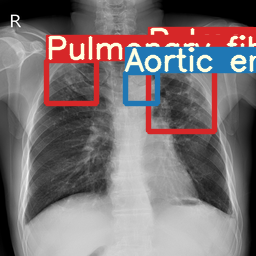

In [ ]:
Image(filename='./runs/detect/exp2/ffccf1709d0081d122a1d1f9edbefdf1.png', width=256)


In [ ]:
!ls -l ../images/train |wc

   3516   31637  277698


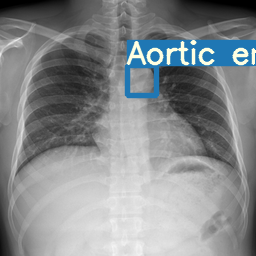

In [ ]:
Image(filename='./runs/detect/exp/002a34c58c5b758217ed1f584ccbcfe9.png', width=256)

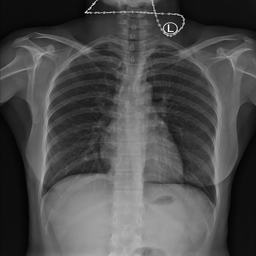

In [ ]:
Image(filename='../train/7f5387855924e012224cd2bdf1da5b26.png', width=256)


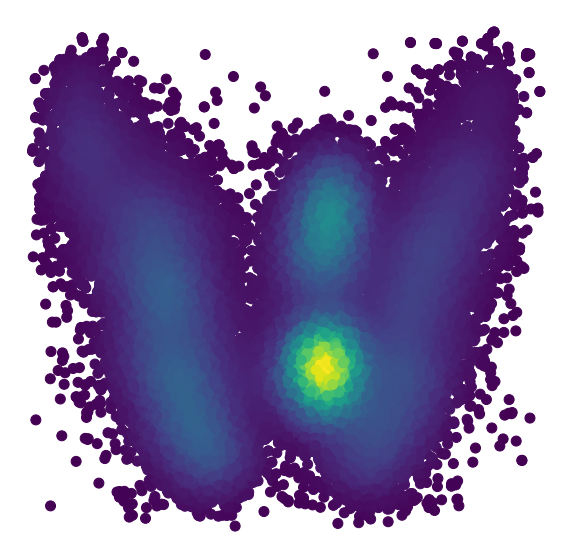

In [ ]:
from scipy.stats import gaussian_kde


x_val = train_df.x_mid.values
y_val = train_df.y_mid.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

In [ ]:
from scipy.stats import gaussian_kde


x_val = train_df.x_mid.values
y_val = train_df.y_mid.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

TypeError: ignored